### Interpret Results

In [1]:
# Run this script to add the src directory to the python path

from notebook_utils import modify_sys_path, get_src_dir_path

modify_sys_path()

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import re
from csaps import csaps
import scienceplots

from src.utils import calculate_min_Va_by_KL_threshold, calculate_min_Va_by_KL_rank



In [93]:
plt.style.use(['science','no-latex', 'retro', 'grid'])

# Set font size for title
mpl.rcParams['axes.titlesize'] = 26
# Set font size for labels
mpl.rcParams['axes.labelsize'] = 26
# Set font size for tick labels
mpl.rcParams['xtick.labelsize'] = 26
mpl.rcParams['ytick.labelsize'] = 26
mpl.rcParams['legend.fontsize'] = 20

In [3]:
# results_directory = 'results/logistic_regression_3/experiment_2/active_learning/dataset_specified/'

results_directory = 'results/logistic_regression_3/experiment_2_14b_seed_change/'

In [4]:
shots = 15

In [5]:
# Load the results
df_list = []
for filename in os.listdir(get_src_dir_path(results_directory)):
    if f"results_{shots}_shot" in filename:
        save_data = pd.read_csv(get_src_dir_path(results_directory) + filename)
        df_list.append(save_data)

In [6]:
D_data = None

for filename in os.listdir(get_src_dir_path(results_directory)):
    if f"D_{shots}" in filename:
        D_data = pd.read_csv(get_src_dir_path(results_directory) + filename)

In [7]:
feature_column = [col for col in D_data.columns if col != 'label' and col != 'note'][0]


In [8]:
for save_data in df_list:
    # z_data = calculate_min_Va_by_KL_threshold(z_data, threshold=0.005, forward_kl=True)
    save_data = calculate_min_Va_by_KL_rank(save_data, num_valid_Va=5, forward_kl=True)

In [9]:

PROB_LABELS = ["0", "1"]

x_x1_list = []
total_uncertainty_list = []
kl_pyx_pyxz_list = []
kl_pyxz_pyx_list = []
min_Va_list = []    
max_Ve_list = []
z_value_for_min_Va_list = []

prob_y_xz_list = []
prob_y_x_list = []
within_threshold_list = []


for z_df in df_list:
    try:
        x_x1 = z_df[f'x_{feature_column}'].values[0]
        x_x1_list.append(x_x1)
        total_uncertainty = z_df["H[p(y|x,D)]"].values[0]
        total_uncertainty_list.append(total_uncertainty)
        prob_y_xz = {}
        prob_y_x = {}
        # index where z_value_for_min_Va is True
        min_Va_index = z_df[z_df["z_value_for_min_Va"]].index[0]
        z_value_for_min_Va_list.append(z_df[f"z_{feature_column}"].values[min_Va_index])
        for label in PROB_LABELS:
            prob_y_xz[label] = z_df[f"p(y={label}|x,z,D)"].values[min_Va_index]
            prob_y_x[label] = z_df[f"p(y={label}|x,D)"].values[min_Va_index]
        prob_y_xz_list.append(prob_y_xz)
        prob_y_x_list.append(prob_y_x)
        kl_pyx_pyxz = z_df["kl_pyx_pyxz"].values[min_Va_index]
        kl_pyx_pyxz_list.append(kl_pyx_pyxz)
        kl_pyxz_pyx = z_df["kl_pyxz_pyx"].values[min_Va_index]
        kl_pyxz_pyx_list.append(kl_pyxz_pyx)
        min_Va = z_df["min_Va"].values[0]
        min_Va_list.append(min_Va)
        max_Ve = z_df["max_Ve"].values[0]
        max_Ve_list.append(max_Ve)
        
        within_threshold_list.append(z_df[z_df["within_threshold"]][f"z_{feature_column}"].values)
        
    except:
        pass
    
# Create a dataframe from the lists
data = {f'x_{feature_column}': x_x1_list,
        'total_uncertainty': total_uncertainty_list,
        'min_Va': min_Va_list,
        'max_Ve': max_Ve_list,
        'kl_pyx_pyxz': kl_pyx_pyxz_list,
        'kl_pyxz_pyx': kl_pyxz_pyx_list,
        'z_value_for_min_Va': z_value_for_min_Va_list,
        'within_threshold': within_threshold_list
        }

for label in PROB_LABELS:
    data[f"p(y={label}|x,z,D)"] = [d[label] for d in prob_y_xz_list]
    data[f"p(y={label}|x,D)"] = [d[label] for d in prob_y_x_list]

num_Va = len(min_Va_list)

# reduce the length of list to the number of num_Va
for key in data.keys():
    data[key] = data[key][:num_Va]

shots_df = pd.DataFrame(data)

shots_df = shots_df.sort_values(by='x_x1')


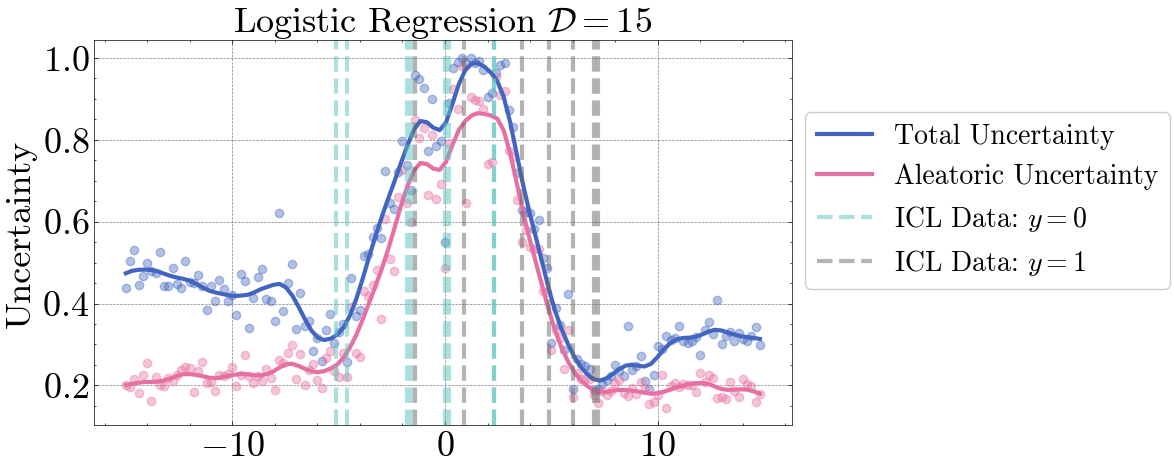

In [95]:
# plot x vs total uncertainty and min Va
# mpl.rcParams['text.usetex'] = True
# plt.rc('text.latex', preamble=r'\usepackage{textgreek}')

plt.figure(figsize=(9, 5))
plt.scatter(shots_df[f'x_{feature_column}'], shots_df['total_uncertainty'], color='C0', alpha=0.4)
plt.scatter(shots_df[f'x_{feature_column}'], shots_df['min_Va'], color='C1', alpha=0.4)

# line of best fit

x_grid = np.linspace(shots_df[f'x_{feature_column}'].min(), shots_df[f'x_{feature_column}'].max(), 100)
y_total_uncertainty = csaps(shots_df[f'x_{feature_column}'], shots_df['total_uncertainty'], smooth=0.85)
y_min_Va = csaps(shots_df[f'x_{feature_column}'], shots_df['min_Va'], smooth=0.85)

plt.plot(x_grid, y_total_uncertainty(x_grid), color='C0', linewidth = 3, label='Total Uncertainty')
plt.plot(x_grid, y_min_Va(x_grid), color='C1', linewidth = 3, label='Aleatoric Uncertainty')


# vertical line for the true x
label_0_seen = False
label_1_seen = False
for i, row in D_data.iterrows():
    if row['label'] == 0:
        if not label_0_seen:
            label_0_seen = True
            label_string = r'ICL Data: $y = 0$'
        else:
            label_string = None
        plt.axvline(x=row[feature_column], color='C2', linestyle='--', linewidth=3, alpha=0.5, label=label_string)
    else:
        if not label_1_seen:
            label_1_seen = True
            label_string = r'ICL Data: $y = 1$'
        else:
            label_string = None
        plt.axvline(x=row[feature_column], color='C3', linestyle='--', linewidth=3, alpha=0.5, label=label_string)
plt.title(rf"Logistic Regression $\mathcal{{D}} = {shots}$")

# plt.yscale('log')
plt.ylabel('Uncertainty')
plt.legend(bbox_to_anchor=(1, 0.85))
# plt.legend()
plt.savefig(f'figures/logistic_regression/uncertainty_decomposition_logistic_regression.pdf', dpi=300, bbox_inches='tight', pad_inches=0.01)

plt.show()

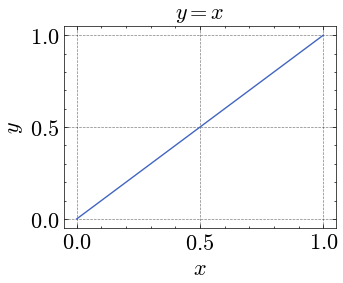

In [36]:
plt.figure()
plt.plot([0, 1], [0, 1])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'$y = x$')  # math rendered, but no LaTeX backend needed
plt.show()

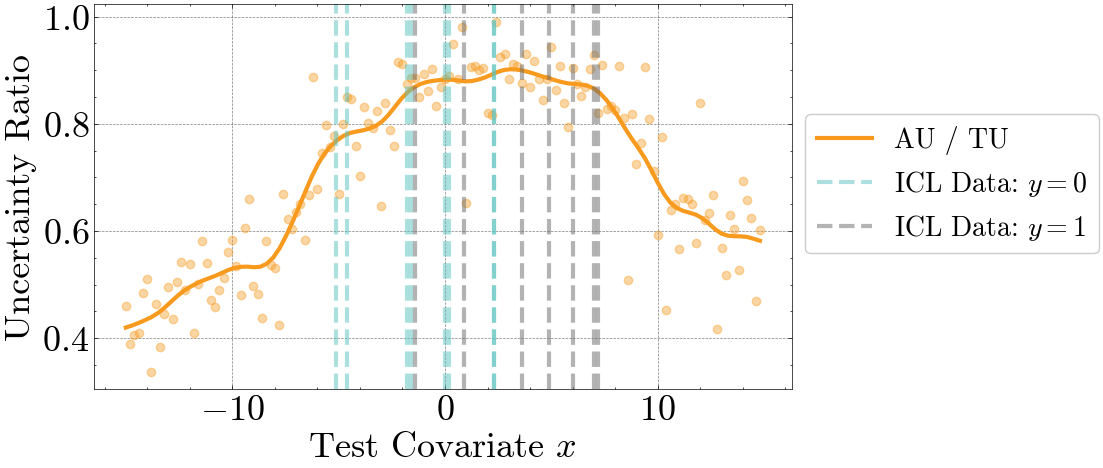

In [96]:
# min Va total uncertainty ratio

shots_df['min_Va_total_uncertainty_ratio'] = shots_df['min_Va'] / shots_df['total_uncertainty']

x_grid = np.linspace(shots_df[f'x_{feature_column}'].min(), shots_df[f'x_{feature_column}'].max(), 100)
y_total_uncertainty_ratio = csaps(shots_df[f'x_{feature_column}'], shots_df['min_Va_total_uncertainty_ratio'], smooth=0.5)


plt.figure(figsize=(9, 5))
plt.scatter(shots_df['x_x1'], shots_df['min_Va_total_uncertainty_ratio'], color='C4', alpha=0.4)
plt.plot(x_grid, y_total_uncertainty_ratio(x_grid), linewidth=3, color='C4', label='AU / TU')

# vertical line for the true x
label_0_seen = False
label_1_seen = False
for i, row in D_data.iterrows():
    if row['label'] == 0:
        if not label_0_seen:
            label_0_seen = True
            label_string = r'ICL Data: $y = 0$'
        else:
            label_string = None
        plt.axvline(x=row[feature_column], color='C2', linewidth=3, linestyle='--', alpha=0.5, label=label_string)
    else:
        if not label_1_seen:
            label_1_seen = True
            label_string = r'ICL Data: $y = 1$'
        else:
            label_string = None
        plt.axvline(x=row[feature_column], color='C3', linewidth=3, linestyle='--', alpha=0.5, label=label_string)

plt.ylabel('Uncertainty Ratio')

plt.xlabel(r'Test Covariate $x$')
# plt.legend()
plt.savefig(f'figures/logistic_regression/uncertainty_decomposition_ratio_logistic_regression.pdf', bbox_inches='tight', dpi=300, pad_inches=0.01)

# plt.title(f"min Va / total uncertainty for {shots} shots")
plt.legend(bbox_to_anchor=(1, 0.75))

# plt.yscale('log')
plt.show()

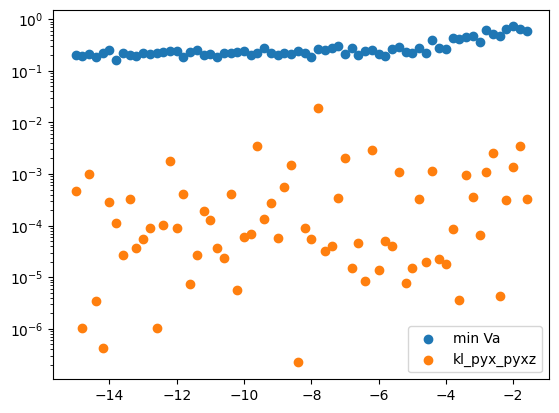

In [11]:
# plot x vs the kl divergence

plt.figure()
plt.scatter(shots_df['x_x1'], shots_df['min_Va'], label='min Va')
plt.scatter(shots_df['x_x1'], shots_df['kl_pyx_pyxz'], label='kl_pyx_pyxz')
plt.yscale('log')
plt.legend()
plt.show()


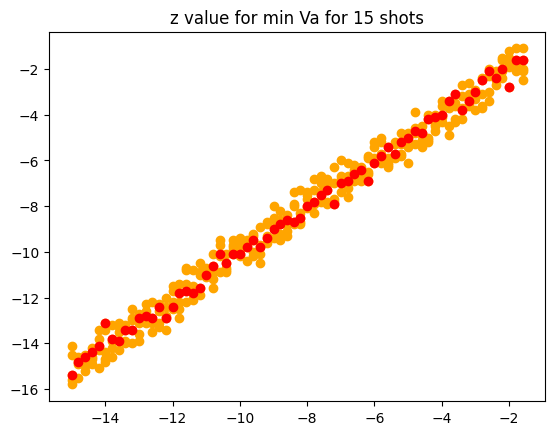

In [12]:
# plot x vs z_value_for_min_Va and within_threshold_values


plt.figure()
for i, row in shots_df.iterrows():
    x = row["x_x1"]
    within_threshold = row["within_threshold"]
    for value in within_threshold:
        plt.scatter(x, value, c='orange')
plt.scatter(shots_df['x_x1'], shots_df['z_value_for_min_Va'], c='r', label='z_value_for_min_Va')
plt.title(f"z value for min Va for {shots} shots")
plt.show()